## Intro
In this notebook, I build an encoder that encodes a perfume into 240-dimension representation by its top, middle and base notes. This process is done by training a neural network to encode and predict a perfume's fragrance by its notes. The final accuracy of the model is only 55% but through the process, the model learn a good representation of the perfumes, which we can use to explore the relationships of the perfumes.

The following notebook is organized into 3 parts:
1. Data Preparation
2. Building and Training the Model 
3. Model Performance Evaluation
4. Explore the Perfume Representations

### Data Preparation

In [1]:
import pandas as pd
import numpy as np

np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

#### Data Cleaning

In [2]:
df = pd.read_csv('data/perfumes.csv')

# top, middle, and base notes are all required in our inputs. Drop the row if any of them are missing
df = df[~df[['top','middle','base']].isna().any(1)]
df['top'] = df['top'].fillna('[]').apply(eval)
df['middle'] = df['middle'].fillna('[]').apply(eval)
df['base'] = df['base'].fillna('[]').apply(eval)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23907 entries, 0 to 37801
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   iurl       23907 non-null  object 
 1   title      23907 non-null  object 
 2   ifullname  23907 non-null  object 
 3   cnname     23743 non-null  object 
 4   enname     23907 non-null  object 
 5   s0         23907 non-null  int64  
 6   s1         23907 non-null  int64  
 7   isscore    23907 non-null  float64
 8   istotal    23907 non-null  int64  
 9   ptimevote  23907 non-null  int64  
 10  brand      23907 non-null  object 
 11  brandid    23907 non-null  int64  
 12  attrib     23872 non-null  object 
 13  perfumer   9709 non-null   object 
 14  fragrance  22284 non-null  object 
 15  top        23907 non-null  object 
 16  middle     23907 non-null  object 
 17  base       23907 non-null  object 
 18  mainodor   23907 non-null  object 
 19  perfumers  9709 non-null   object 
 20  wikida

In [3]:
df['fragrance'].value_counts()

花香果香调     3030
花香调       2434
东方花香调     2332
木质花香调     1941
木质馥奇香调    1267
木质东方调     1093
馥奇香调       951
东方调        873
辛辣木质调      851
花果香美食调     789
柑橘馥奇香调     733
花香西普调      713
辛辣东方调      599
东方美食调      563
绿叶花香调      551
辛辣馥奇香调     369
皮革调        332
木质调        316
东方馥奇香调     312
柑橘调        307
水生馥奇香调     258
水生花香调      238
西普调        229
果香馥奇香调     217
醛香花香调      215
果香西普调      206
绿叶馥奇香调     175
木质西普调      167
水生木质调      137
柑橘美食调       69
绿叶调          6
果香调          5
美食调          4
水生调          2
Name: fragrance, dtype: int64

We have a lot of fragrances here! Some of the fragrances have too few samples and might be confusing for our model. We can group the fragrances into several families to reduce the sparcity. The following mapping is found from nosetime.com. 

In [4]:
fragrance_adj = {
    '辛辣木质调': '木质调',
     '花香果香调': '果香调',
     '木质东方调': '东方调',
     '水生花香调': '花香调',
     '果香调': '果香调',
     '花香调': '花香调',
     '木质馥奇香调': '馥奇香调',
     '木质花香调': '花香调',
     '木质西普调': '西普调',
     '花香西普调': '西普调',
     '柑橘馥奇香调': '馥奇香调',
     '绿叶花香调': '花香调',
     '醛香花香调': '花香调',
     '东方馥奇香调': '馥奇香调',
     '东方调': '东方调',
     '皮革调': '皮革调',
     '果香馥奇香调': '馥奇香调',
     '东方花香调': '花香调',
     '辛辣东方调': '东方调',
     '绿叶馥奇香调': '馥奇香调',
     '木质调': '木质调',
     '果香西普调': '西普调',
     '柑橘调': '柑橘调',
     '辛辣馥奇香调': '馥奇香调',
     '东方美食调': '美食调',
     '花果香美食调': '美食调',
     '西普调': '西普调',
     '馥奇香调': '馥奇香调',
     '水生木质调': '木质调',
     '水生馥奇香调': '馥奇香调',
     '柑橘美食调': '美食调',
     '绿叶调': '绿叶调',
     '美食调': '美食调',
     '水生调': '水生调'
}
df['fragrance'] = df['fragrance'].map(fragrance_adj)
df['fragrance'].value_counts()

花香调     7711
馥奇香调    4282
果香调     3035
东方调     2565
美食调     1425
西普调     1315
木质调     1304
皮革调      332
柑橘调      307
绿叶调        6
水生调        2
Name: fragrance, dtype: int64

4 categories, '皮革调', '柑橘调', '绿叶调' and '水生调', still have less than 1000 samples. I'll simply replace them with nan and exclude them from our task.

In [5]:
df.loc[df['fragrance'].isin(['皮革调', '柑橘调', '绿叶调', '水生调']), 'fragrance'] = np.nan
df['fragrance'].value_counts()

花香调     7711
馥奇香调    4282
果香调     3035
东方调     2565
美食调     1425
西普调     1315
木质调     1304
Name: fragrance, dtype: int64

#### Constructing Vocabularies
Before we can feed the data into neural networks, we need to code the fragrance notes and outputs into integers and we need to store the mapping for reverse lookup.

In [6]:
def contruct_note_voc(df):
    voc = {}
    for perf in df.iterrows():
        for note in ['top','middle','base']:
            for ing in perf[1][note]:
                voc[ing] = voc.get(ing, 0) + 1

    voc = pd.Series(voc)
    
    # keep only the notes that appeared more than 50 times
    voc = voc[voc>=50]
    voc = voc.reset_index()['index']
    voc.index += 1 # we need to avoid 0 as index since we will do zero padding later 

    voc_dict = voc.to_dict()
    # add UNK for notes not in the vocabulary
    voc_dict[len(voc)+1] = 'UNK'
    voc_dict_rev = {value:key for key, value in voc_dict.items()}
    
    return voc_dict, voc_dict_rev

voc_dict, voc_dict_rev = contruct_note_voc(df)

In [7]:
# hand-code the dict for the 7 outputs
output_dict = {0:'木质调', 1:'果香调', 2:'东方调', 3:'花香调', 4:'馥奇香调', 5:'西普调', 6:'美食调'}
output_dict_rev = {value:key for key, value in output_dict.items()}

#### Construct Training / Test Data Set
Apply the code mapping to convert all inputs and outputs into integers and pad the inputs, then hold out 10% of the data as testing data.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_datasets(df, ratio):
    df['y'] = df['fragrance'].map(output_dict_rev)
    df = df[~df['y'].isna()]

    df['x_t'] = df['top'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    df['x_m'] = df['middle'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    df['x_b'] = df['base'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    
    dataset = df[['x_t','x_m','x_b','y']]
    train = dataset.sample(frac=ratio)
    test = dataset.drop(train.index)
    
    train_x, train_y = [train['x_t'].values, train['x_m'].values, train['x_b'].values], train['y'].values
    test_x, test_y = [test['x_t'].values, test['x_m'].values, test['x_b'].values], test['y'].values

    train_x = [pad_sequences(i, maxlen=10) for i in train_x]
    test_x = [pad_sequences(i, maxlen=10) for i in test_x]
    
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = get_datasets(df, 0.9)

Now let's see how our dataset looks like!

In [10]:
def check_sample_data(sample_index):
    input_x = [notes[sample_index] for notes in train_x]
    output_x = train_y[sample_index]
    print('Input for the sample {} is:'.format(sample_index))
    for i in input_x:
        print(i)
    print('The 3 arrays represent respectively the top, middle, and top notes of this perfume.')
    print('The top notes of the perfume are {}'.format([voc_dict[i] for i in input_x[0] if i != 0]))
    print('The middle notes of the perfume are {}'.format([voc_dict[i] for i in input_x[1] if i != 0]))
    print('The base notes of the perfume are {}'.format([voc_dict[i] for i in input_x[2] if i != 0]), '\n')
    print('Output for the sample {} is:'.format(sample_index))
    print(output_x)
    print('which represents the fragrance: {}'.format(output_dict.get(output_x, 'null')), '\n')
    
for sample_index in range(3):
    check_sample_data(sample_index)

Input for the sample 0 is:
[ 0  0  0  0  0  0  0  0 11 87]
[  0   0   0   0   0   0   0  31 121  56]
[ 0  0  0  0  0  0 42  4 52 15]
The 3 arrays represent respectively the top, middle, and top notes of this perfume.
The top notes of the perfume are ['莲花', '梨']
The middle notes of the perfume are ['桂花', '天芥菜', '铃兰']
The base notes of the perfume are ['木质香', '广藿香', '檀香木', '麝香'] 

Output for the sample 0 is:
1.0
which represents the fragrance: 果香调 

Input for the sample 1 is:
[ 0  0  0  0  0  0 70 26 25 17]
[ 0  0  0  0  0 85 80 51 55 58]
[  0   0   0  52  19  15   7 117  53   6]
The 3 arrays represent respectively the top, middle, and top notes of this perfume.
The top notes of the perfume are ['醛', '橙花', '香柠檬', '柠檬']
The middle notes of the perfume are ['公丁香', '鸢尾根', '茉莉', '依兰', '玫瑰']
The base notes of the perfume are ['檀香木', '琥珀', '麝香', '安息香脂', '麝猫香', '香草', '香根草'] 

Output for the sample 1 is:
3.0
which represents the fragrance: 花香调 

Input for the sample 2 is:
[  0   0   0   0   0   

### Build and Train the Model

#### Define the Custom Callback Class
PlotProgress class: a callback class to plot the learning curves.
CustomSave class: a custom checkpoint class that starts to save best model after several epochs

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import datetime
from IPython.display import clear_output
from matplotlib import pyplot as plt

class PlotProgress(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.plot_x = []
        self.plot_loss = []
        self.plot_val_loss = []
        self.plot_acc = []
        self.plot_val_acc = []

    def on_epoch_end(self, epoch, logs):
        clear_output(wait=True)
        self.plot_x.append(epoch)
        self.plot_loss.append(logs['loss'])
        self.plot_val_loss.append(logs['val_loss'])
        self.plot_acc.append(logs['accuracy'])
        self.plot_val_acc.append(logs['val_accuracy'])
        
        plt.figure(figsize=(10,5))
        
        plt.subplot(121)
        plt.plot(self.plot_x, self.plot_loss, label='loss')
        plt.plot(self.plot_x, self.plot_val_loss, label='val_loss')
        plt.title('Loss')
        plt.legend()
        
        plt.subplot(122)
        plt.plot(self.plot_x, self.plot_acc, label='accuracy')
        plt.plot(self.plot_x, self.plot_val_acc, label='val_accuracy')
        plt.title('Accuracy')
        plt.legend()
        
        plt.show()
        
class CustomSave(keras.callbacks.Callback):
    def __init__(self, start_epoch):
        self.start_epoch = start_epoch
        
    def on_train_begin(self, logs):
        self.min_val_loss = 999

    def on_epoch_end(self, epoch, logs):
        val_loss = logs['val_loss']
        if val_loss < self.min_val_loss:
            if epoch >= self.start_epoch:
                print('Saving best model...')
                self.model.save('best_model.h5')
                self.min_val_loss = val_loss

#### Building the Model
The idea of the model is to rely most of the work on the encoding layers, so that it can learn a good representation of the perfumes.

1. The top, mid, and base notes are inputed and shuffled within themselves because the order of the notes should not matter;
2. The inputs go through an emdedding lay and get vetorized. Each note is represented by a 128-dimension vector;
3. Since the number of notes for each perfume is not fixed, we feed the notes into RNN (here I use LSTM for better fitting ability) to compress them into fixed dimension space;
4. Concate the states of the three RNN, the perfume is finally encoded into 180-dimension vector;
5. Feed the encoded vectors into a 7-node dense layer to compute probability of each output, and go through softmax layer to get a final prediction. 



In [12]:
input_top = keras.Input(shape=(None,), dtype="int32")
input_mid = keras.Input(shape=(None,), dtype="int32")
input_base = keras.Input(shape=(None,), dtype="int32")

shuffle =  layers.Lambda(lambda x: tf.map_fn(tf.random.shuffle, x))

input_top_shuffled = shuffle(input_top)
input_mid_shuffled = shuffle(input_mid)
input_base_shuffled = shuffle(input_base)

embedding = layers.Embedding(len(voc_dict)+1, 128, mask_zero=True)

top_vec = embedding(input_top_shuffled)
mid_vec = embedding(input_mid_shuffled)
base_vec = embedding(input_base_shuffled)

top_encoded = layers.LSTM(80)(top_vec)
mid_encoded = layers.LSTM(80)(mid_vec)
base_encoded = layers.LSTM(80)(base_vec)
encoded = layers.Concatenate()([top_encoded,mid_encoded,base_encoded])

fragrance = layers.Dense(7, activation="sigmoid")(encoded)
fragrance = layers.Softmax()(fragrance)

model = keras.Model([input_top, input_mid, input_base], fragrance)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

#### Compile and Train

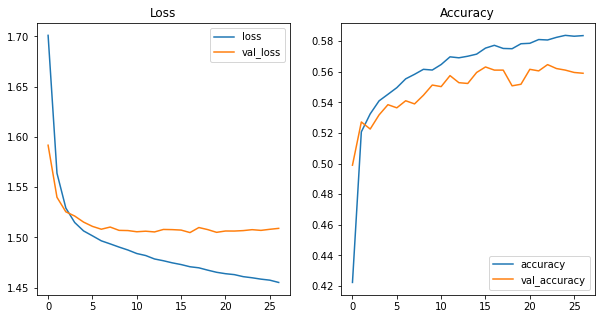

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
plot_callback = PlotProgress()
save_callback = CustomSave(5)

model.fit(train_x, train_y, batch_size=100, epochs=500, validation_split=0.1, 
          callbacks=[early_stopping_callback, plot_callback, save_callback])

### Model Performance Evaluation

In [15]:
model = keras.models.load_model('best_model.h5')
# compute loss and accuracy on test data
model.evaluate(test_x, test_y)

68/68 [==============================] - 6s 4ms/step - loss: 1.5275 - accuracy: 0.5536


[1.5275298357009888, 0.5536044239997864]

In [17]:
from sklearn.metrics import confusion_matrix

pred = model.predict_on_batch(test_x).argmax(1)
cm = confusion_matrix(pred, test_y)

print('Accuracy: {:.1%}'.format((cm*np.eye(7)).sum() / cm.sum()))
print('Confusion Matrix:\n', pd.DataFrame(cm, index=output_dict.values(), columns=output_dict.values()), '\n')

Accuracy: 55.0%
Confusion Matrix:
       木质调  果香调  东方调  花香调  馥奇香调  西普调  美食调
木质调    13    0    9    3     8    2    0
果香调     0   44    3   21    12    4   12
东方调    28    1   97   36    28   11   11
花香调    13  207   68  675    63   91   72
馥奇香调   80   11   53   52   322   32    8
西普调     0    0    0    0     0    0    0
美食调     1    5   12   10     4    2   40 



### Explore the Perfume Representations from the Encoder
The deeper layers including input, embedding, and RNN layers are used to encode the perfume by its fragrance notes. After training on the task, they should be optimized to learn a good representation of the perfume's fragrance.

Let's explore the representations by:
1. Encode perfumes into representations and visualize their relationships by T-SNE;
2. Calculate cosine distances between perfumes and find similar perfumes.

In [18]:
encoder = keras.Model([input_top, input_mid, input_base], encoded)

def encoding(df, encoder):   
    df['x_t'] = df['top'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    df['x_m'] = df['middle'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    df['x_b'] = df['base'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    
    notes =  [df['x_t'].values, df['x_m'].values, df['x_b'].values]
    notes = [pad_sequences(i, maxlen=10) for i in notes]

    encoded = encoder(notes)
    
    return encoded

#### 1. Encode & Visualize

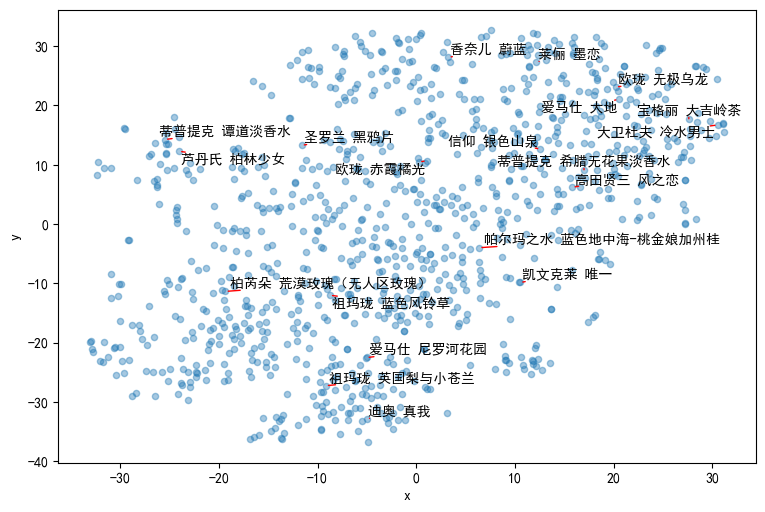

In [19]:
from sklearn.manifold import TSNE
import matplotlib
from adjustText import adjust_text

plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["figure.dpi"] = 100

perfumes = df.nlargest(1000, 'istotal').set_index('title') # encode top 1000 perfumes
representation = pd.DataFrame(encoding(perfumes, encoder), index=perfumes.index)
representation2D = TSNE(early_exaggeration=40).fit_transform(representation)
representation2D = pd.DataFrame(representation2D, index=perfumes.index, columns=['x','y'])

ax = representation2D.plot('x','y', kind='scatter', figsize=(9,6), alpha=0.4)
texts = [ax.text(row[1]['x'], row[1]['y'], row[1]['title']) for row in representation2D.reset_index()[:20].iterrows()]
adjust_text(texts, arrowprops={'arrowstyle':'-','color':'r'})
plt.show()

#### 2. Calculate Cosine Distance & Find Similar Perfumes

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

names = list(representation.index)
pair_cosine_dist = pd.DataFrame(np.triu(cosine_similarity(representation),1), index=names, columns=names)
pair_cosine_dist.index.name = 'perfume_1'
pair_cosine_dist.columns.name = 'perfume_2'

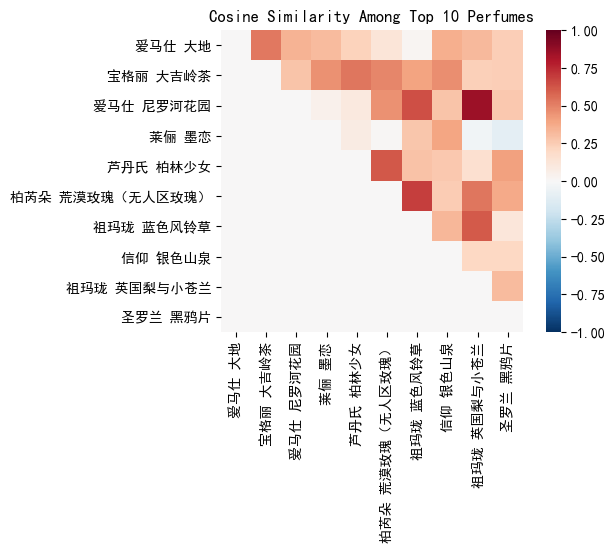

In [21]:
import seaborn as sns
sns.heatmap(pair_cosine_dist.iloc[:10,:10], cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True)
plt.title('Cosine Similarity Among Top 10 Perfumes')
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [22]:
pair_cosine_dist = pair_cosine_dist.stack().rename('cosine').reset_index()
pair_high_cosine = pair_cosine_dist[pair_cosine_dist['cosine']>0.9]
print('There are {} pairs of perfume that have cosine similarity of more than 0.9.\n'.format(len(pair_high_cosine)))

example = pair_high_cosine.sample(1).values[0]
print('An example of such pair is:')
print('{} and {}, with {:.2f} cosine similarity.'.format(*example))
perfume1 = perfumes.loc[example[0]]
perfume2 = perfumes.loc[example[1]]

for perfume in [perfume1, perfume2]:
    print('\nTitle:', perfume.name)
    print('Fragrance:', perfume.fragrance)
    print('Top Notes:', ', '.join(perfume.top))
    print('Middle Notes:', ', '.join(perfume.middle))
    print('Base Notes:', ', '.join(perfume.base))

There are 567 pairs of perfume that have cosine similarity of more than 0.9.

An example of such pair is:
兰蔻 奇迹绽放 and 迪奥 紫色魅惑, with 0.94 cosine similarity.

Title: 兰蔻 奇迹绽放
Fragrance: 花香调
Top Notes: 苹果, 橘子, 荔枝
Middle Notes: 玫瑰, 茉莉, 牡丹
Base Notes: 檀香木, 麝香

Title: 迪奥 紫色魅惑
Fragrance: 花香调
Top Notes: 桃子, 树莓, 石榴
Middle Notes: 茉莉, 玫瑰, 铃兰
Base Notes: 麝香, 雪松


We can also find a perfume's most similar neighbors.

In [23]:
pair_cosine_dist[(pair_cosine_dist['perfume_1']=='穆勒 青净古龙水')|
                 (pair_cosine_dist['perfume_2']=='穆勒 青净古龙水')].nlargest(10,'cosine')

,perfume_1,perfume_2,cosine
90684,穆勒 青净古龙水,汤姆·福特 橙花之水（绝漾海岸）,0.889260
90443,穆勒 青净古龙水,别样公司 桂花,0.863288
90924,穆勒 青净古龙水,潘海利根 土耳其浴花束,0.855933
76090,祖玛珑 红玫瑰,穆勒 青净古龙水,0.843886
90404,穆勒 青净古龙水,梅森·马吉拉 绿茶逃逸,0.830012
90907,穆勒 青净古龙水,爱马仕 闻香系列-刀锋薰衣草,0.826763
90737,穆勒 青净古龙水,迪奥 典藏系列-雾暖茶香,0.821424
67090,潘海利根 月亮女神,穆勒 青净古龙水,0.819655
90255,穆勒 青净古龙水,宝格丽 蓝茶古龙（茗蓝）,0.819592
90759,穆勒 青净古龙水,香奈儿 19号淡雅倾心版,0.817899
